In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report


Found 38422 images belonging to 11 classes.
1201/1201 [==============================] - 611s 509ms/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.95      0.96      0.95      4268
                        Early_blight       0.97      0.98      0.97      3714
                         Late_blight       0.91      0.88      0.90      5300
                           Leaf_Mold       0.86      0.94      0.90      3304
                  Septoria_leaf_spot       0.96      0.92      0.94      4350
Spider_mites Two-spotted_spider_mite       0.99      0.98      0.99      2618
                         Target_Spot       0.99      0.99      0.99      2740
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.97      0.98      3044
                 Tomato_mosaic_virus       1.00      0.97      0.99      3282
                             healthy       0.99      0.99      0.99      4296
            

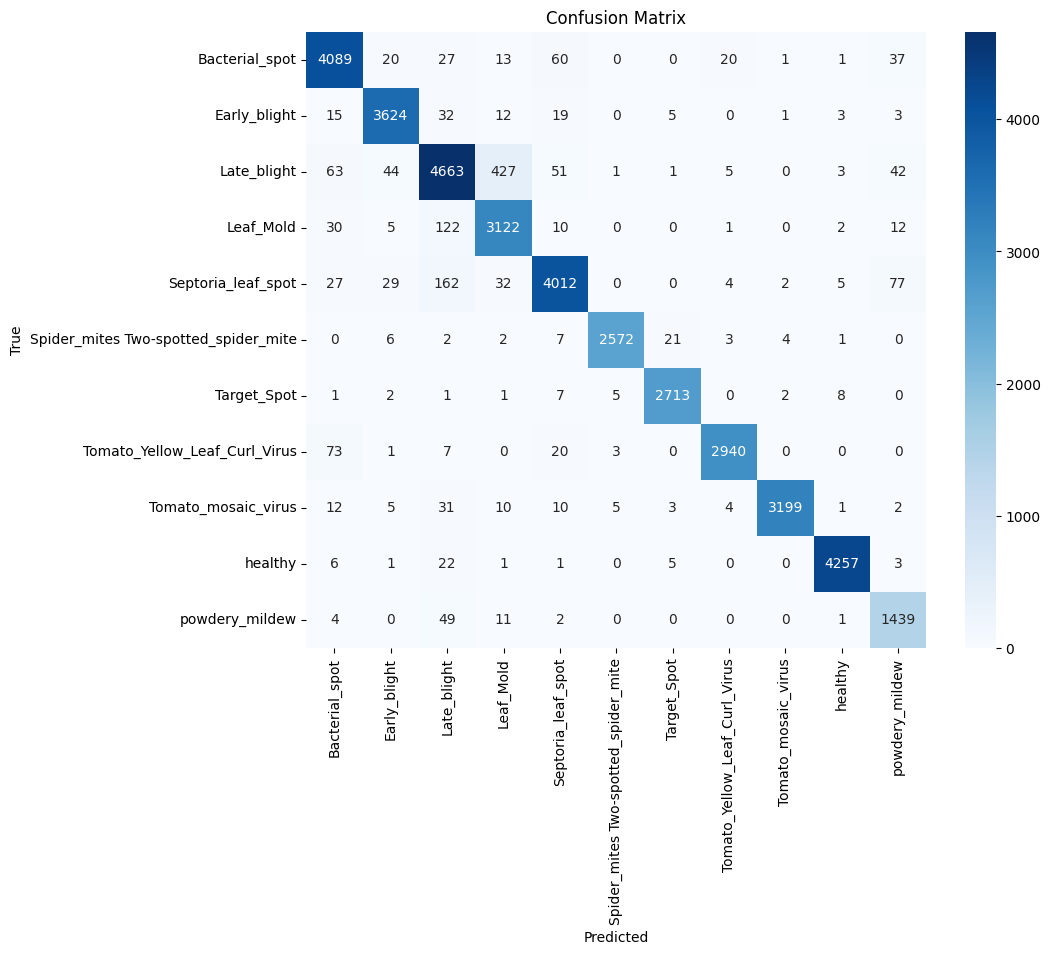

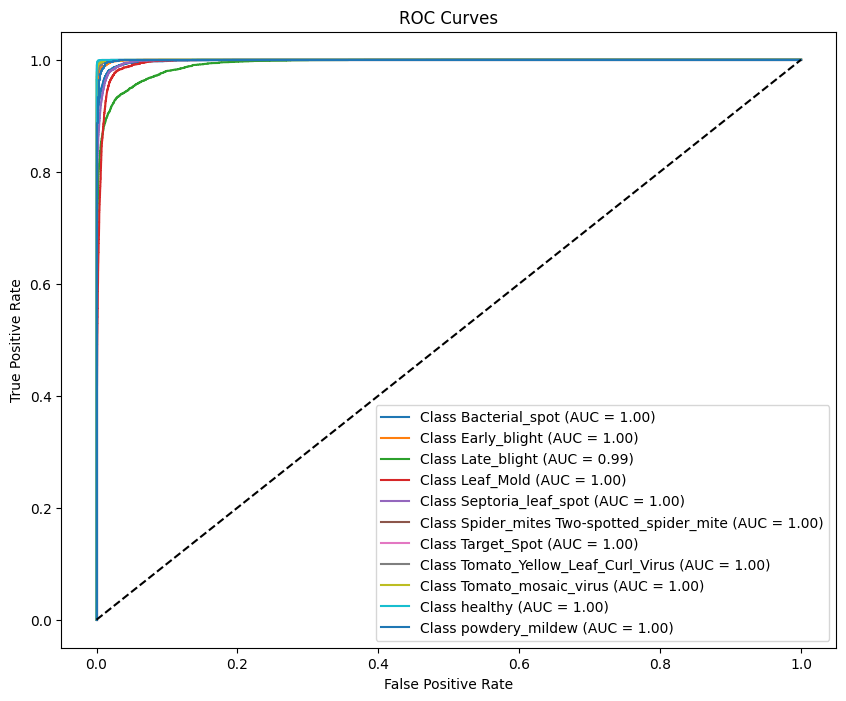

In [8]:

# Cargar modelo preentrenado
model = load_model('best_model_Concatenated CNN.h5')  # Cambia al nombre correcto del modelo

# Preparar el generador de imágenes para las imágenes de prueba
test_dir = "train"  # Cambia a la ruta relativa adecuada
image_size = (224, 224)  # Cambia según el tamaño esperado del modelo

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predicciones del modelo
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 1. Calcular métricas: Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 2. Matriz de Confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Graficar curva ROC y calcular AUC
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


In [9]:
def evaluate_model(model, test_dir, image_size=(224, 224), batch_size=32):
    """
    Evalúa un modelo de clasificación utilizando imágenes de prueba.
    
    Parámetros:
    - model: Modelo cargado de Keras.
    - test_dir: Ruta al directorio que contiene las imágenes de prueba organizadas en subcarpetas por clase.
    - image_size: Tamaño de las imágenes (tupla), por defecto (224, 224).
    - batch_size: Tamaño del batch para la evaluación, por defecto 32.
    
    Retorna:
    - metrics: Diccionario con las métricas Precision, Recall, F1-Score y AUC por clase.
    - conf_matrix: Matriz de confusión.
    """
    # Preparar las imágenes de prueba
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Generar predicciones
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Calcular métricas
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Imprimir reporte
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Graficar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Graficar curvas ROC y calcular AUC
    auc_scores = {}
    plt.figure(figsize=(10, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_labels[i]] = roc_auc
        plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    # Retornar métricas y matriz de confusión
    metrics = {
        'classification_report': report,
        'auc_scores': auc_scores
    }
    return metrics, conf_matrix


In [12]:
# Ruta a las imágenes de prueba
test_dir = "test"

# Modelos a comparar
model1 = load_model('best_model_Simple CNN.h5')
model2 = load_model('best_model_Concatenated CNN.h5')
model3 = load_model('best_model_Separable CNN.h5')
model4 = load_model('best_model_Isolated CNN.h5')


Found 6422 images belonging to 11 classes.
201/201 [==============================] - 66s 330ms/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.88      0.86      0.87       714
                        Early_blight       0.83      0.81      0.82       620
                         Late_blight       0.76      0.61      0.68       886
                           Leaf_Mold       0.65      0.79      0.71       552
                  Septoria_leaf_spot       0.73      0.75      0.74       728
Spider_mites Two-spotted_spider_mite       0.92      0.92      0.92       438
                         Target_Spot       0.88      0.79      0.84       458
       Tomato_Yellow_Leaf_Curl_Virus       0.95      0.92      0.93       508
                 Tomato_mosaic_virus       0.95      0.91      0.93       548
                             healthy       0.88      0.95      0.91       716
                

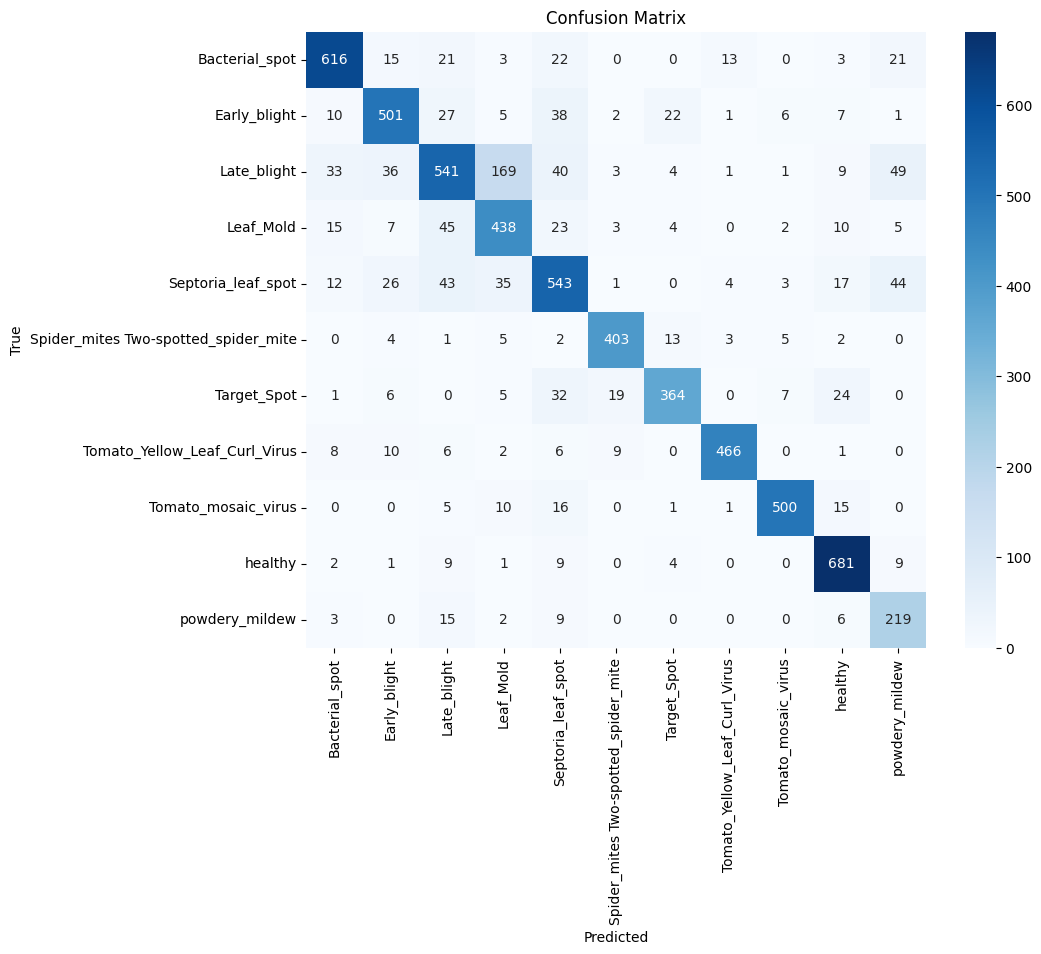

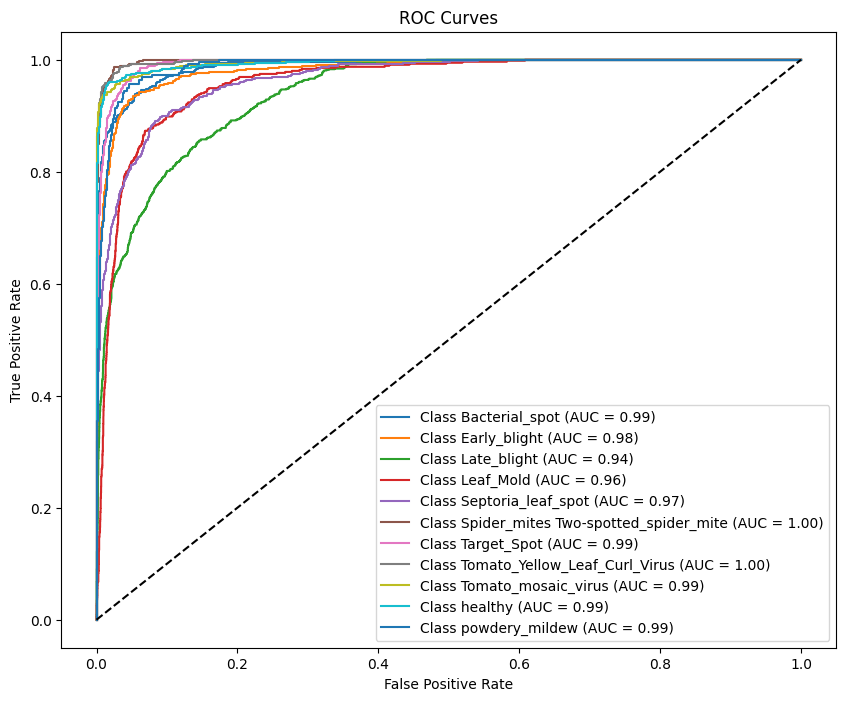

Found 6422 images belonging to 11 classes.
201/201 [==============================] - 96s 475ms/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.83      0.83      0.83       714
                        Early_blight       0.75      0.74      0.75       620
                         Late_blight       0.58      0.60      0.59       886
                           Leaf_Mold       0.57      0.72      0.64       552
                  Septoria_leaf_spot       0.74      0.71      0.72       728
Spider_mites Two-spotted_spider_mite       0.84      0.84      0.84       438
                         Target_Spot       0.79      0.79      0.79       458
       Tomato_Yellow_Leaf_Curl_Virus       0.91      0.86      0.89       508
                 Tomato_mosaic_virus       0.96      0.89      0.92       548
                             healthy       0.91      0.85      0.88       716
                

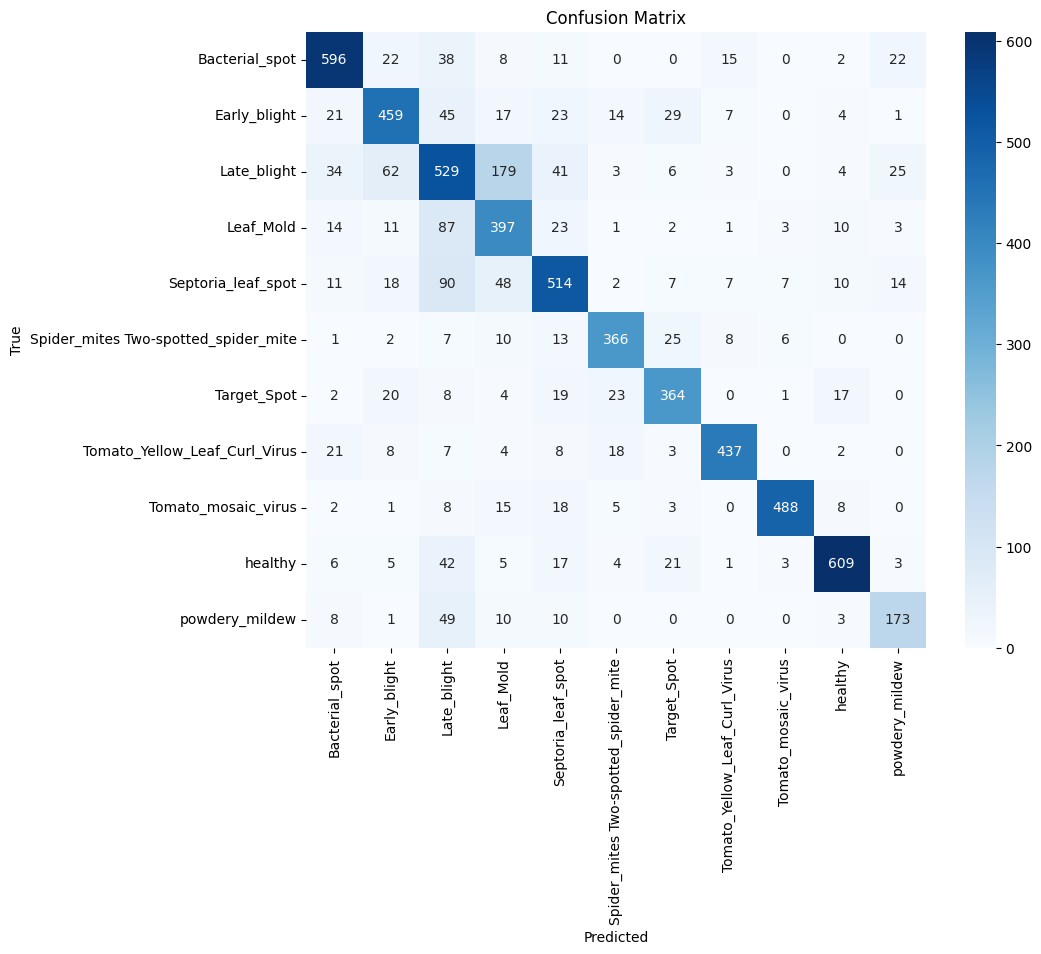

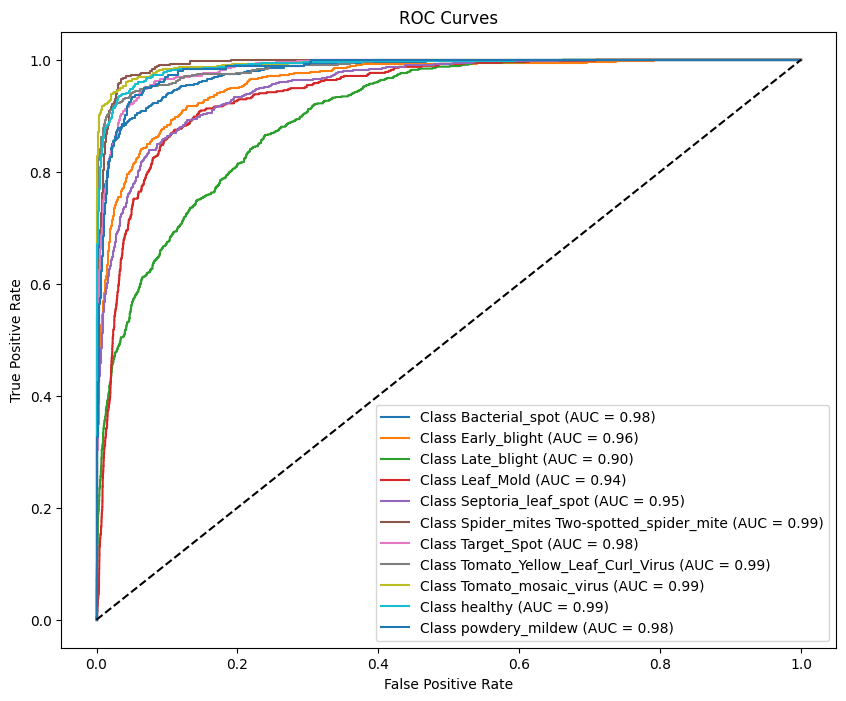

Found 6422 images belonging to 11 classes.
201/201 [==============================] - 36s 179ms/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.86      0.78      0.82       714
                        Early_blight       0.78      0.75      0.76       620
                         Late_blight       0.62      0.59      0.61       886
                           Leaf_Mold       0.66      0.73      0.69       552
                  Septoria_leaf_spot       0.73      0.64      0.68       728
Spider_mites Two-spotted_spider_mite       0.83      0.96      0.89       438
                         Target_Spot       0.88      0.80      0.84       458
       Tomato_Yellow_Leaf_Curl_Virus       0.93      0.91      0.92       508
                 Tomato_mosaic_virus       0.95      0.92      0.93       548
                             healthy       0.86      0.93      0.89       716
                

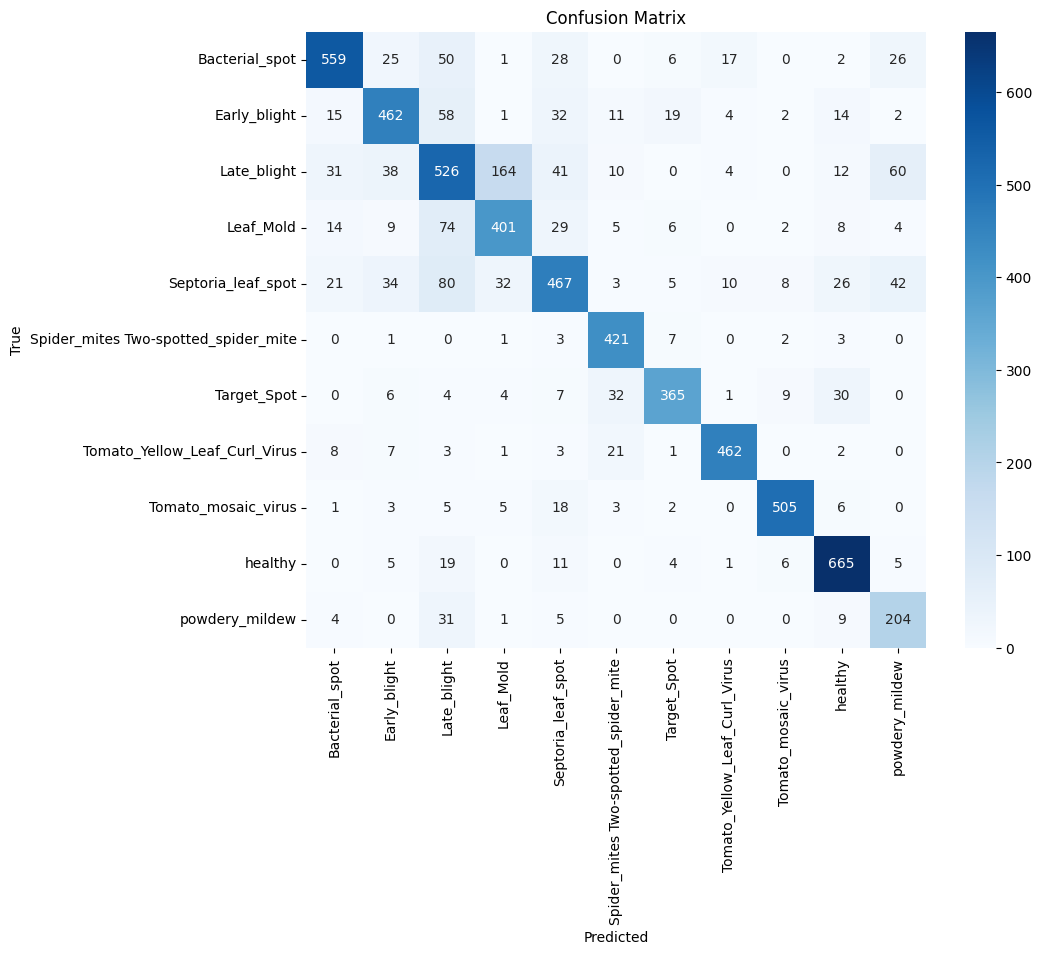

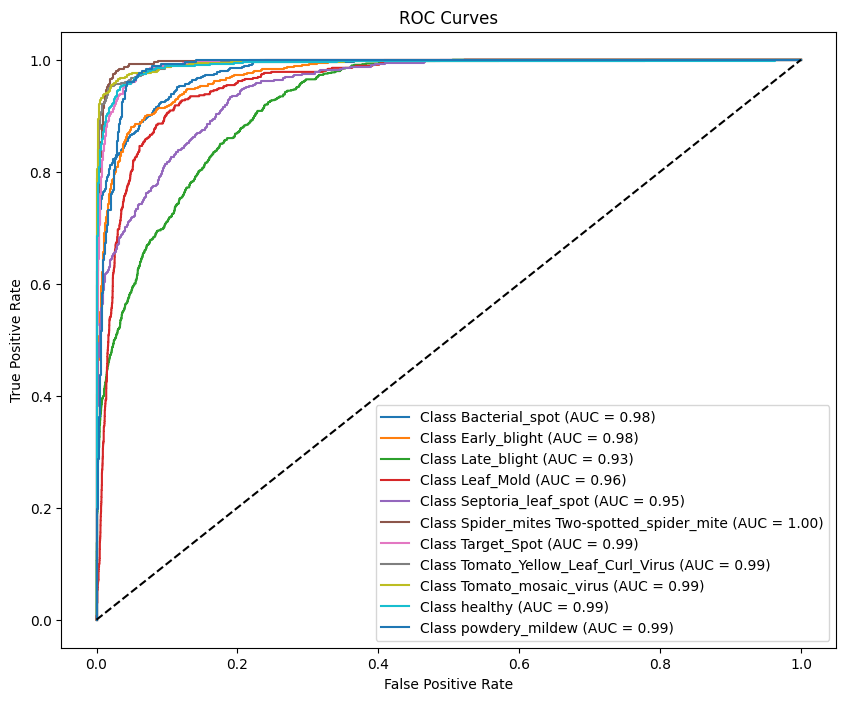

Found 6422 images belonging to 11 classes.
201/201 [==============================] - 98s 486ms/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.82      0.80      0.81       714
                        Early_blight       0.78      0.65      0.71       620
                         Late_blight       0.61      0.62      0.61       886
                           Leaf_Mold       0.66      0.58      0.62       552
                  Septoria_leaf_spot       0.61      0.78      0.68       728
Spider_mites Two-spotted_spider_mite       0.80      0.89      0.84       438
                         Target_Spot       0.73      0.80      0.76       458
       Tomato_Yellow_Leaf_Curl_Virus       0.93      0.88      0.90       508
                 Tomato_mosaic_virus       0.95      0.89      0.92       548
                             healthy       0.91      0.85      0.88       716
                

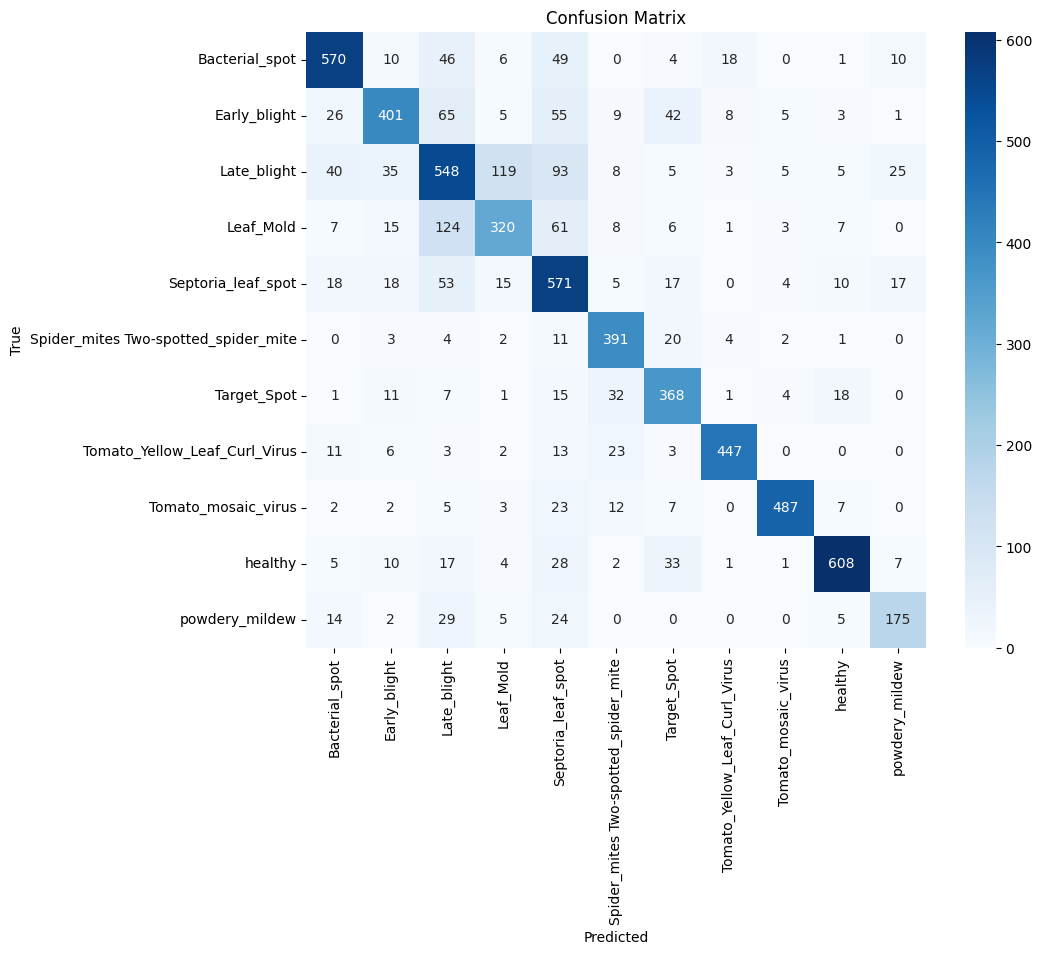

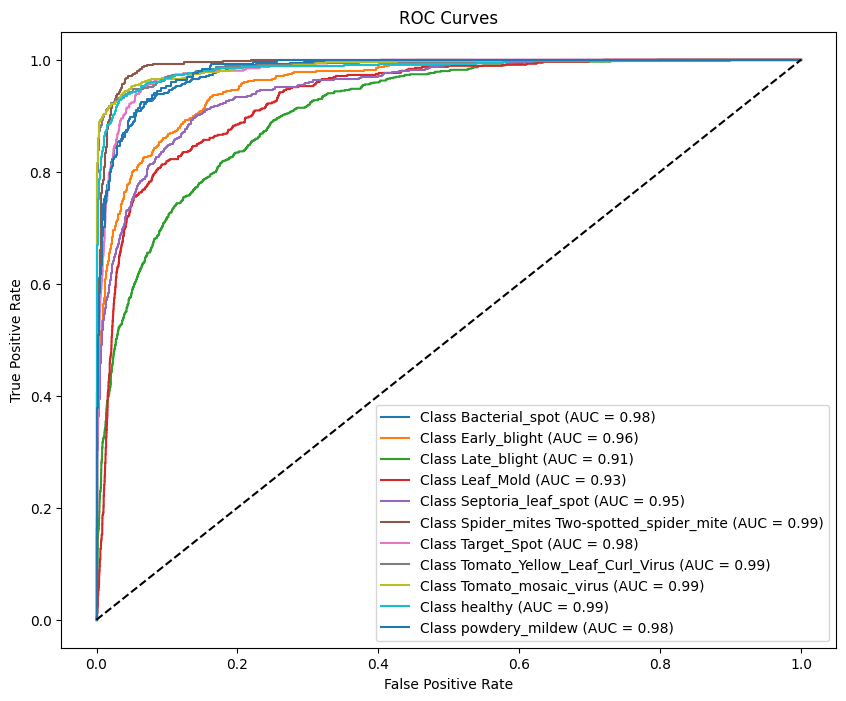

Modelo 1 - AUC Scores: {'Bacterial_spot': 0.9882535004190884, 'Early_blight': 0.9823862183229365, 'Late_blight': 0.9419438251086263, 'Leaf_Mold': 0.9604368812186752, 'Septoria_leaf_spot': 0.9655971004759202, 'Spider_mites Two-spotted_spider_mite': 0.9976844645080947, 'Target_Spot': 0.9931796016272306, 'Tomato_Yellow_Leaf_Curl_Virus': 0.9975954561310544, 'Tomato_mosaic_virus': 0.9941577258685436, 'healthy': 0.9942151454804997, 'powdery_mildew': 0.9886153579051645}
Modelo 2 - AUC Scores: {'Bacterial_spot': 0.9793181813720583, 'Early_blight': 0.9613356350980196, 'Late_blight': 0.9043381347942954, 'Leaf_Mold': 0.9423075142582031, 'Septoria_leaf_spot': 0.9538310521582387, 'Spider_mites Two-spotted_spider_mite': 0.9922468286816595, 'Target_Spot': 0.9845481184047516, 'Tomato_Yellow_Leaf_Curl_Virus': 0.987056603974554, 'Tomato_mosaic_virus': 0.9928858833558252, 'healthy': 0.9893985944423884, 'powdery_mildew': 0.983945586568216}
Modelo 3 - AUC Scores: {'Bacterial_spot': 0.9794126480304807, 'Ear

In [13]:

# Evaluar modelos
metrics1, conf_matrix1 = evaluate_model(model1, test_dir, image_size=(224, 224))
metrics2, conf_matrix2 = evaluate_model(model2, test_dir, image_size=(224, 224))
metrics3, conf_matrix1 = evaluate_model(model3, test_dir, image_size=(224, 224))
metrics4, conf_matrix2 = evaluate_model(model4, test_dir, image_size=(224, 224))

# Comparar métricas
print("Modelo 1 - AUC Scores:", metrics1['auc_scores'])
print("Modelo 2 - AUC Scores:", metrics2['auc_scores'])
print("Modelo 3 - AUC Scores:", metrics3['auc_scores'])
print("Modelo 4 - AUC Scores:", metrics4['auc_scores'])


In [25]:
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

def create_model():
    """Recrear la arquitectura del modelo original"""
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_count = 11  # número de clases en tu modelo

    # Crear el modelo base
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False, 
        weights=None,  # No cargar pesos de ImageNet
        input_shape=img_shape, 
        pooling='max'
    )

    # create pre-trained model
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
])

    return model


modules loaded


In [26]:
import os
import json
import tensorflow as tf

def load_complete_model_with_custom_architecture(base_path):
    """
    Carga un modelo usando una función de creación personalizada y pesos guardados.
    
    Parámetros:
    - base_path: Ruta base del modelo (sin extensiones, e.g., 'models/model_name')
    
    Retorna:
    - model: Modelo reconstruido con pesos cargados.
    """
    try:
        # Recrear el modelo usando la arquitectura personalizada
        model = create_model()
        
        # Cargar pesos
        weights_path = base_path + '_weights'
        model.load_weights(weights_path)
        
        print(f"Modelo cargado exitosamente desde: {base_path}")
        return model
    except Exception as e:
        print(f"Error al cargar el modelo: {str(e)}")
        return None


Modelo cargado exitosamente desde: models/TomatoDisease_acc_0.9871
Found 6422 images belonging to 11 classes.
201/201 [==============================] - 265s 1s/step

Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00       714
                        Early_blight       0.00      0.00      0.00       620
                         Late_blight       0.00      0.00      0.00       886
                           Leaf_Mold       0.00      0.00      0.00       552
                  Septoria_leaf_spot       0.00      0.00      0.00       728
Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00       438
                         Target_Spot       0.00      0.00      0.00       458
       Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00       508
                 Tomato_mosaic_virus       0.00      0.00      0.00       548
                             

c:\Users\JOWAKO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JOWAKO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JOWAKO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

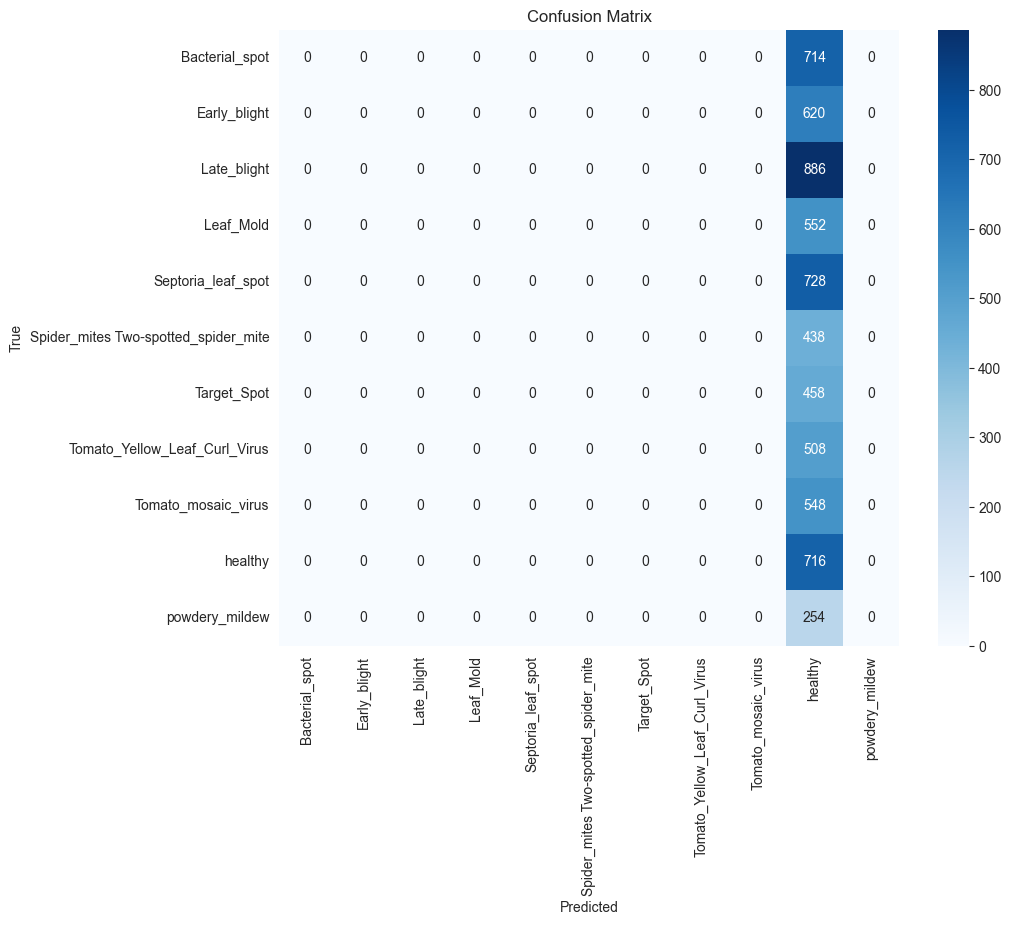

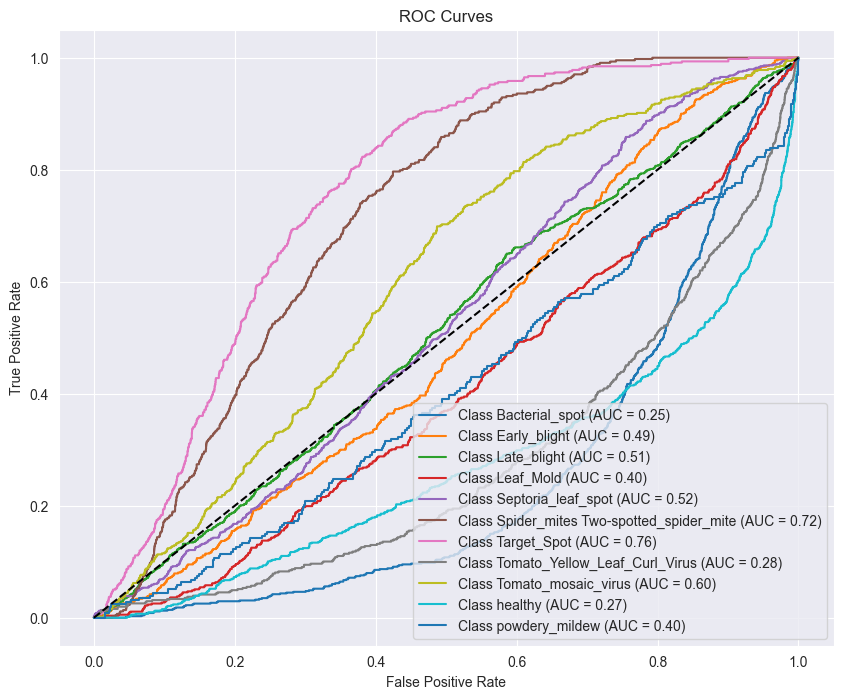

AUC por clase: {'Bacterial_spot': 0.25304489350049764, 'Early_blight': 0.4898565288943746, 'Late_blight': 0.5111507970811205, 'Leaf_Mold': 0.40239966792583265, 'Septoria_leaf_spot': 0.5223298720071639, 'Spider_mites Two-spotted_spider_mite': 0.7174020370912997, 'Target_Spot': 0.7602454245121383, 'Tomato_Yellow_Leaf_Curl_Virus': 0.2791321274221852, 'Tomato_mosaic_virus': 0.6030032445342459, 'healthy': 0.27175610990685095, 'powdery_mildew': 0.40278501179570453}


In [27]:
# Ruta base del modelo guardado
model_base_path = 'models/TomatoDisease_acc_0.9871'

# Ruta del conjunto de prueba
test_dir = "test"

# Cargar el modelo
model = load_complete_model_with_custom_architecture(model_base_path)
if model is None:
    print(f"Error al cargar el modelo desde: {model_base_path}")
else:
    # Evaluar el modelo
    metrics, conf_matrix = evaluate_model(model, test_dir, image_size=(224, 224))

    # Mostrar métricas importantes
    print(f"AUC por clase: {metrics['auc_scores']}")
